# Random Network Simulations

In [1]:
import random, os
import numpy as np
import pandas as pd

import tellurium as te
from libsbml_draw import SBMLlayout

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

### Load Models

In [2]:
r_15_species = te.loadSBMLModel(r"..\networks\15_species_network.xml")
r_8_species = te.loadSBMLModel(r"..\networks\8_species_network.xml")

In [3]:
ant_15_species = te.sbmlToAntimony(r"..\networks\15_species_network.xml")
ant_8_species = te.sbmlToAntimony(r"..\networks\8_species_network.xml")

### Model Details

In [180]:
print(ant_8_species)

// Created by libAntimony v2.12.0.3
model *doc0()

  // Compartments and Species:
  compartment compartment_;
  species S1 in compartment_, S2 in compartment_, S3 in compartment_, S4 in compartment_;
  species S5 in compartment_, S6 in compartment_, S7 in compartment_, S8 in compartment_;
  species $S_in in compartment_, S_out in compartment_;

  // Reactions:
  r1: $S_in => S7; S2*(kf_J1*S_in/K1_J1 - kr_J1*S7/K2_J1)/(1 + S_in/K1_J1 + S7/K2_J1);
  r2: S8 => S_out; S5*(kf_J2*S8/K1_J2 - kr_J2*S_out/K2_J2)/(1 + S8/K1_J2 + S_out/K2_J2);
  r3: S_out => S8; S1*(kf_J3*S_out/K2_J3 - kr_J3*S8/K1_J3)/(1 + S_out/K2_J3 + S8/K1_J3);
  r4: S3 => S8 + S5; kf_J4*S3 - kr_J4*S8*S5;
  r5: S7 => S6 + S4; kf_J5*S7 - kr_J5*S6*S4;
  r6: S4 + S6 => S3; kf_J6*S4*S6 - kr_J6*S3;

  // Species initializations:
  S1 = 0.430570015589594/compartment_;
  S2 = 0.244570243558996/compartment_;
  S3 = 28.324643372651/compartment_;
  S4 = 5.92313871803477/compartment_;
  S5 = 12.517567535823/compartment_;
  S6 = 5.9251357

### Model Networks

updating network


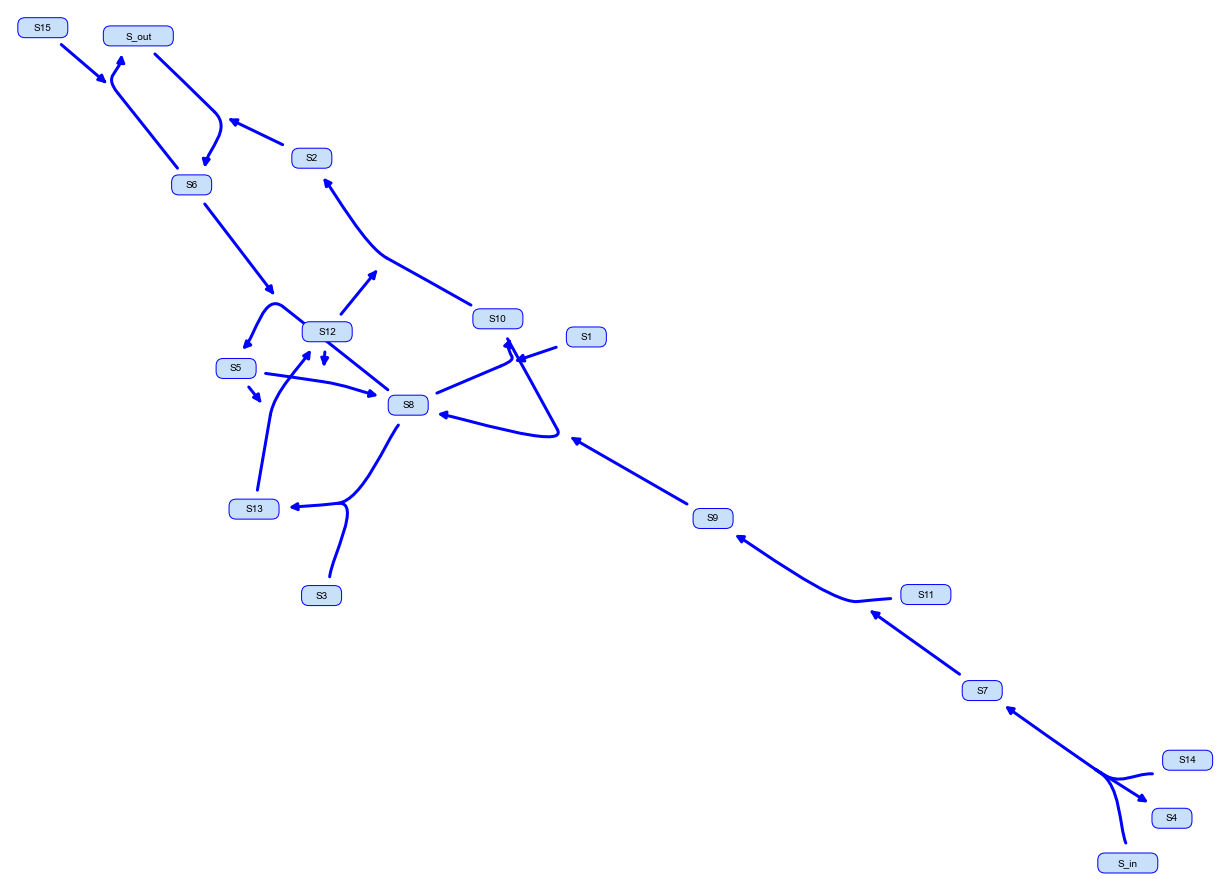

In [8]:
s = SBMLlayout(r"..\networks\15_species_network.xml")
s.drawNetwork(r"..\networks\15_species_network.pdf", show=False)

#### Reaction r1

$$S_{in} + S14 => S7 + S4$$ $$kf_{J1}*S_{in}*S14 - kr_{J1}*S7*S4$$

updating network


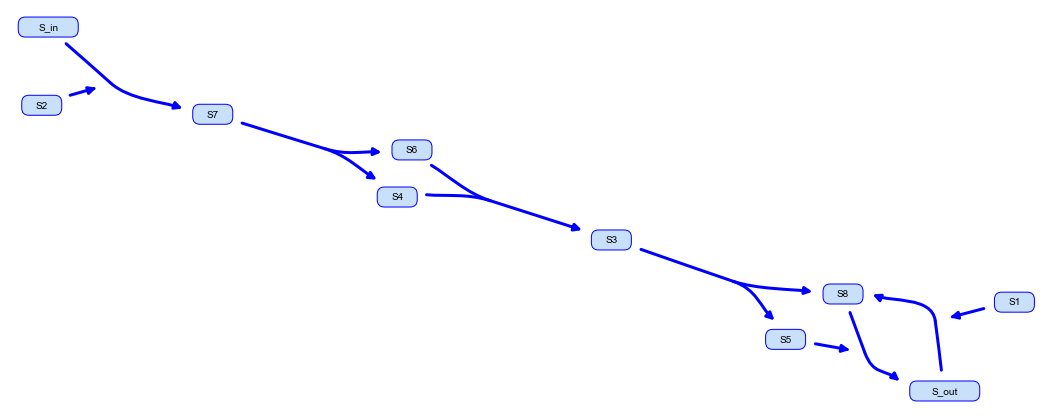

In [70]:
s = SBMLlayout(r"..\networks\8_species_network.xml")
s.drawNetwork(r"..\networks\8_species_network-1.pdf", show=False)

### Initial Model Parameters

We have models with parameters initialized at steady state. We need to adjust these in order to start system in unsteady state (realistic bio scenario).

In [15]:
## How to extract species starting amounts
r_8_species.model['S1']

0.430570015589594

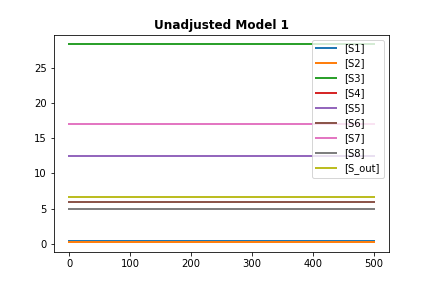

In [16]:
## System at steady state
result_1 = r_8_species.simulate(0, 500)
r_8_species.plot(result_1, title = 'Unadjusted Model 1')

### Adjust Parameters

How to adjust parameters

Concentration vs Amount

r.model['init([S1])'] - Set Concentration

r.model['init(S1)'] - Set Amount

In [17]:
## Adjust all params
r_8_species.model.setFloatingSpeciesInitAmounts([2.6, 7,8])
r_8_species.model.setFloatingSpeciesInitConcentrations([1.2, 34.5])

2

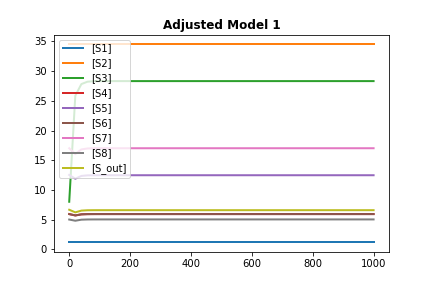

In [18]:
result_1 = r_8_species.simulate(0, 1000)
r_8_species.plot(result_1, title = 'Adjusted Model 1')

In [19]:
## Reset paramters back to initial values
r_8_species.resetToOrigin()

### Simulate Data

Create a dataset by simulating the system with different starting parameters. Take the final value of the system at steady state (t=1000). Collect into dataframe. Class lets you simulate different starting values for species and rates. Set specific species or all. Rates function isn't finished/not sure it will work.

In [62]:
class SimulateData:
    
    """
    Class to simulate data for Tellurium SBML network. Can adjust different species or 
    parameters using ODE or SDE simulation.
    ---
    sbml: Tellurium sbml graph
    """
    
    def __init__(self, sbml):
        
        self.sbml = sbml
        self.sbml.resetToOrigin()
        
    def plot_last_sim(self):
        
        """
        Simple function to plot the results of the final simulation run.
        """
        
        r_8_species.plot(self.final_model, title = 'Final Model ({0})'.format(self.sim_type))

    def sim_with_adjustment(self, species_adjust = list(), species_manual_adjust = False,
                            rates_adjust = False, rates_manual_adjust = False, sim_type = 'SDE', 
                            n = 1000, distribution = 'Gaussian', full_time = False):
        """
        Function to simulate data with different starting species concentrations
        ---

        species_adjust: list of species to adjust starting points, if blank then adjusts all 
                        starting points, if False no adjustments.
        species_manual_adjust: list of species to adjust to a manual value
        rates_adjust: list of rates to adjust, if blank then adjusts all starting rates, if False no adjustments
        rates_manual_adjust:
        sim_type: one of either SDE or ODE used for simulation.
        n: number of simulations to run
        distribution: What type of distribution should starting species points be sampled from
        full_time: return all timestamps (False) or just final (True)
        """
        
        self.species_adjust = species_adjust
        self.rates_adjust = rates_adjust
        self.distribution = distribution
        self.sim_type = sim_type
        
        if self.distribution == 'Gaussian':
            dist = np.random.normal
        else:
            print('Only normal distributions supported')
            return
        
        self.sim_type = self.sim_type.upper()
        if self.sim_type not in ['SDE', 'ODE']:
            print('sim_type must be one of the following: sde, ode')
            return
        
        ## Initialize species parameters and lists for simulated values
        dataset = list()
        S_in = list()
        rates_tracker = list()
        species_tracker = list()
        
        rate_ids = self.sbml.getGlobalParameterIds()
        params = self.sbml.getFloatingSpeciesConcentrationIds()
        params = ['S_in'] + params ## S_in not included in param listing
        
        ## TODO: Determine best way to adjust species. How to define mean
        ##        and variance. Discrete value or based on initial params.
        for x in range(0, n):
            
            ## Species Adjustment --------------------------------------------------
            if self.species_adjust != False:
                if len(self.species_adjust) > 0:
                    for s in self.species_adjust:
                        if s == 'S_in':
                            new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                            while new_val < 0:
                                new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                            self.sbml.model[s] = new_val
                        else:
                            temp_mean = random.randint(2,10)
                            new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                            while new_val < 0:
                                new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                            self.sbml.model['init([{0}])'.format(s)] = new_val
                    S_in.append(self.sbml.model['S_in'])
                else:
                    for s in params:
                        if s == 'S_in':
                            new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                            while new_val < 0:
                                new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                            self.sbml.model[s] = new_val
                        else:
                            temp_mean = random.randint(2,10)
                            new_val = dist(temp_mean, temp_mean / 3)
                            while new_val < 0:
                                new_val = dist(temp_mean, temp_mean / 3)
                            self.sbml.model['init({0})'.format(s)] = new_val
                    S_in.append(self.sbml.model['S_in'])
            ## Set manually added species
            if species_manual_adjust != False:
                for s in species_manual_adjust.items():
                    self.sbml.model['init({0})'.format(s[0])] = random.uniform(3.0, 8.0)
                    
            ## Rates Adjustment ------------------------------------------------------
            if self.rates_adjust != False:
                if len(self.rates_adjust) > 0:
                    for r in self.rates_adjust:
                        #new_rate = np.random.uniform(size=1)[0]
                        new_rate = np.random.choice([.1,.3,.5,.7,.9],1)[0]
                        self.sbml.model[r] = new_rate
                else:
                    for r in rate_ids:
                        #new_rate = np.random.uniform(size=1)[0]
                        new_rate = np.random.choice([.1,.3,.5,.7,.9],1)[0]
                        self.sbml.model[r] = new_rate
                        temp_tracker.append(new_rate)
            ## Set manually added rates
            if rates_manual_adjust != False:
                for r in rates_manual_adjust.items():
                    self.sbml.model[r[0]] = r[1]
            
            ## Simulate data depending on sim_type -----------------------------------
            ## Track initial conditions for simulation
            rates_tracker.append(self.sbml.getGlobalParameterValues())
            species_tracker.append(self.sbml.getFloatingSpeciesConcentrations()) 
            
            self.sbml.setSeed(1234)
            if self.sim_type == 'ODE':
                model_results = self.sbml.simulate(0, 1000)
            else:
                model_results = self.sbml.gillespie(0, 1000,10000)
            
            if full_time == False:
                temp_result = model_results[-1]
                dataset.append(temp_result)
            else:
                dataset.append(model_results)
            self.final_model = model_results
            self.sbml.resetToOrigin()
        
        ## Push results to pandas dataframe ------------------------------------------
        if full_time == False:
            params.pop(0)
            dataset = pd.DataFrame(dataset, columns = ['time'] + params)
            if len(S_in) == 0:
                S_in = [self.sbml.model['S_in'] for x in range(0,n)]
            dataset.loc[:, '[S_in]'] = S_in
        
        self.sim_results = dataset
        self.rates = rates_tracker
        self.species_init = species_tracker
        

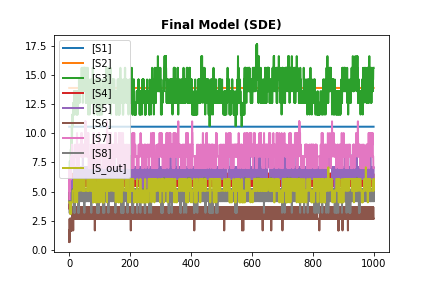

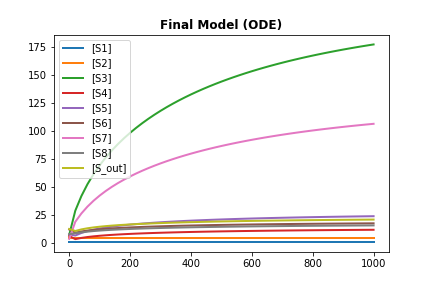

In [5]:
r_8_sim = SimulateData(r_8_species)
r_8_sim.sim_with_adjustment(species_adjust = [], rates_adjust = ['kf_J1', 'kr_J1'], sim_type = 'sde')
sde_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

r_8_sim.sim_with_adjustment(species_adjust = [], rates_adjust = ['kf_J1', 'kr_J1'], sim_type = 'ode')
ode_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

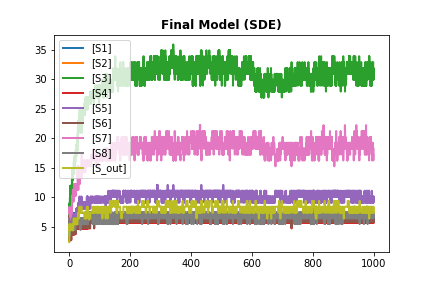

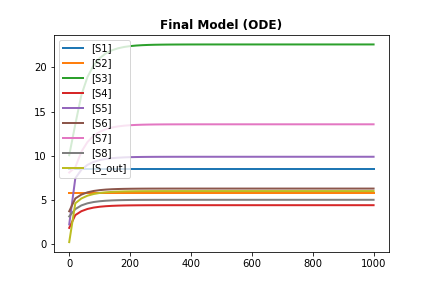

In [26]:
r_8_sim = SimulateData(r_8_species)
r_8_sim.sim_with_adjustment(species_adjust = [], sim_type = 'sde')
sde_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

r_8_sim.sim_with_adjustment(species_adjust = [], sim_type = 'ode')
ode_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

### Plot all simulations on same chart

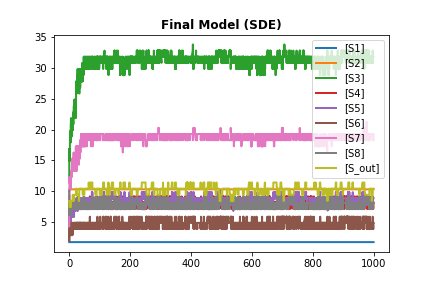

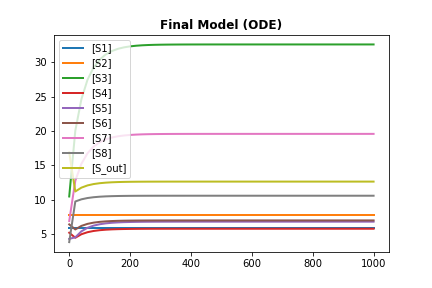

In [85]:
r_8_sim = SimulateData(r_8_species)
r_8_sim.sim_with_adjustment(species_adjust = [], sim_type = 'sde', full_time = True)
sde_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

r_8_sim.sim_with_adjustment(species_adjust = [], sim_type = 'ode', full_time = True)
ode_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

In [86]:
for x in range(0, len(ode_results)):
    ode_results[x] = pd.DataFrame(ode_results[x], 
                                  columns = ['time', '[S1]', '[S2]', '[S3]', '[S4]', '[S5]', 
                                             '[S6]', '[S7]', '[S8]', '[S_out]'])
    ode_results[x].loc[:, 'Sim'] = 'Sim_{0}'.format(str(x))
    
combined_ode = pd.concat(ode_results)
plot_df = combined_ode.loc[combined_ode['Sim'].isin(['Sim_{0}'.format(x) for x in range(0,20)])]


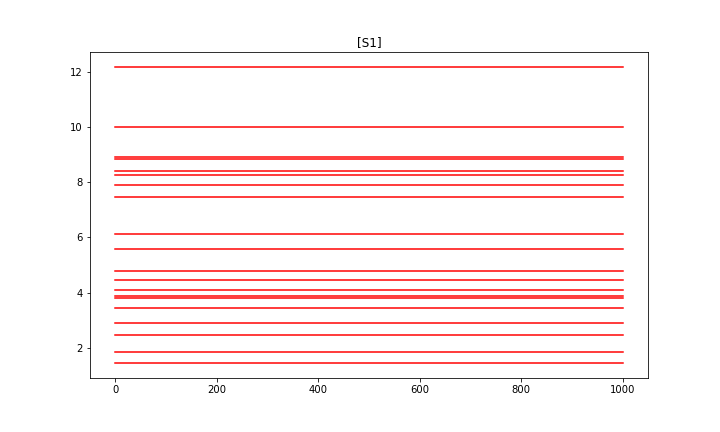

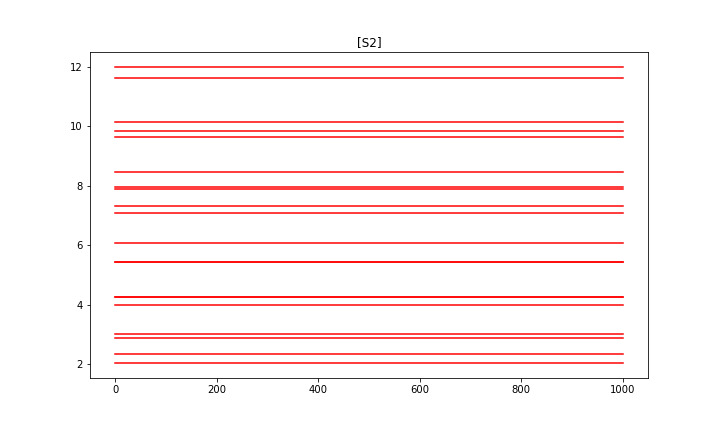

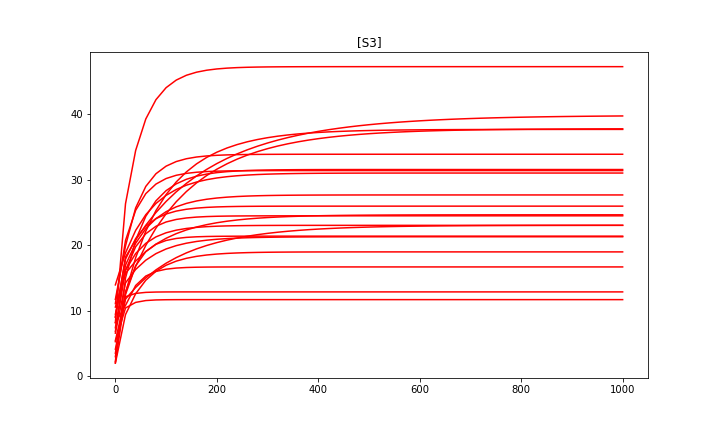

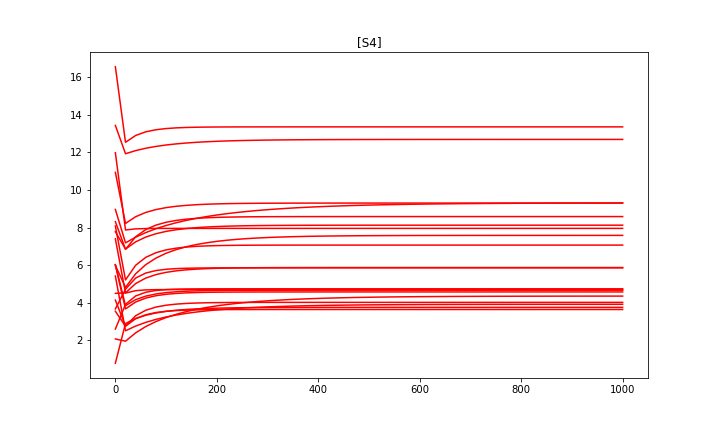

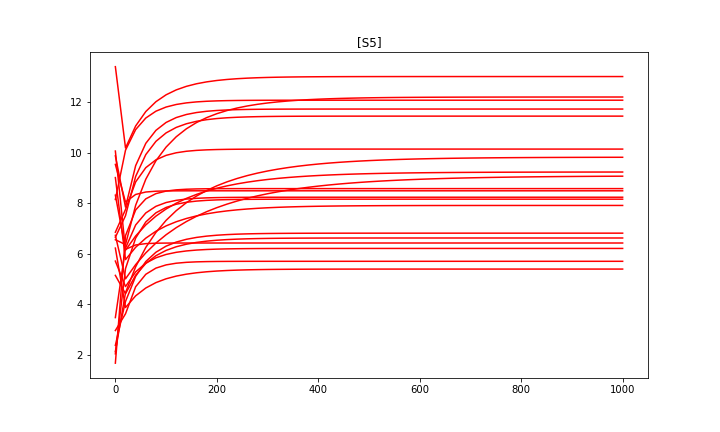

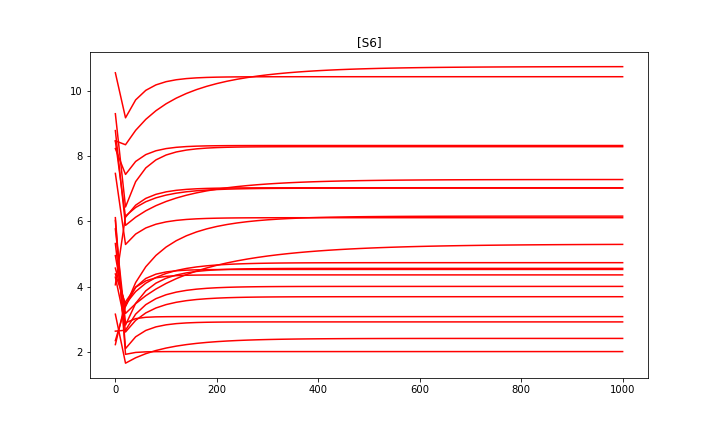

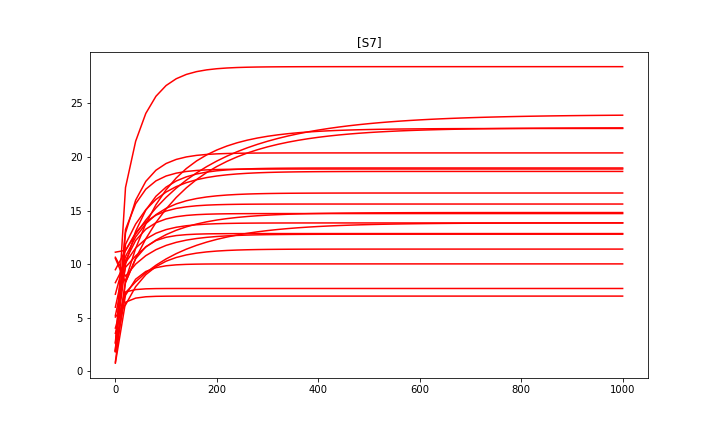

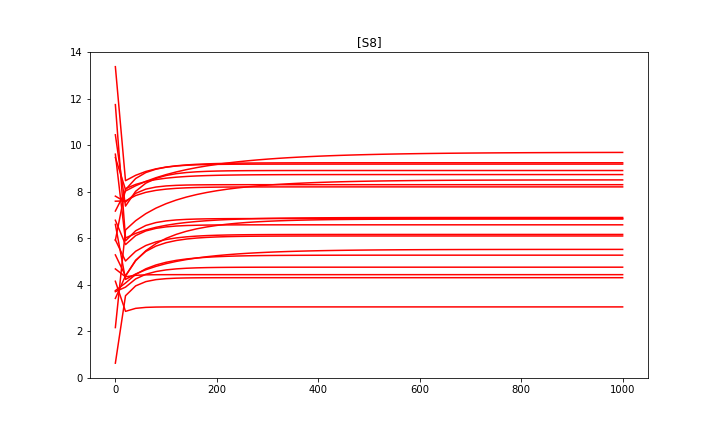

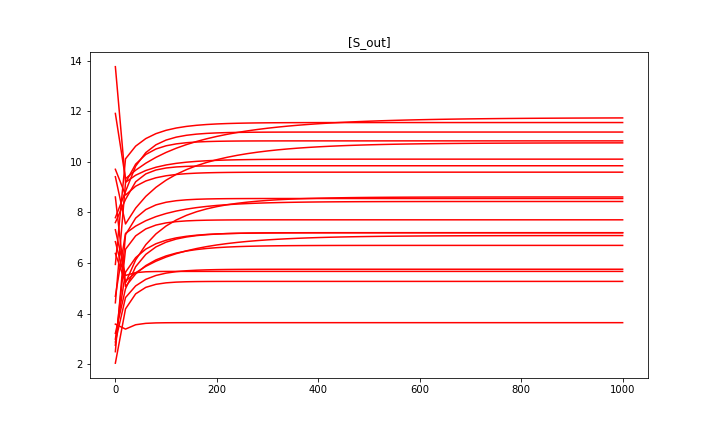

In [92]:
for x in range(0, len(ode_results)):
    ode_results[x] = pd.DataFrame(ode_results[x], 
                                  columns = ['time', '[S1]', '[S2]', '[S3]', '[S4]', '[S5]', 
                                             '[S6]', '[S7]', '[S8]', '[S_out]'])
    ode_results[x].loc[:, 'Sim'] = 'Sim_{0}'.format(str(x))
    
combined_ode = pd.concat(ode_results)
plot_df = combined_ode.loc[combined_ode['Sim'].isin(['Sim_{0}'.format(x) for x in range(0,20)])]

plot_list = ['[S{0}]'.format(str(x)) for x in range(1, 9)]
plot_list.append('[S_out]')

for s in plot_list:
    fig, ax = plt.subplots(figsize = (10,6))
    for x in range(0,40):
        temp = plot_df.loc[plot_df['Sim'] == 'Sim_{0}'.format(x)]
        ax.plot(temp['time'], temp[s], color = 'red')
        ax.set_title(s)

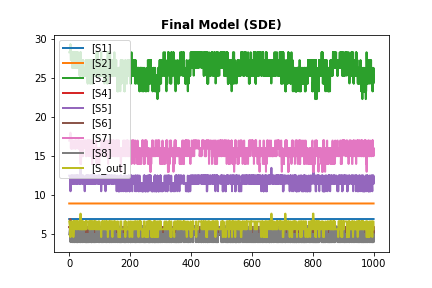

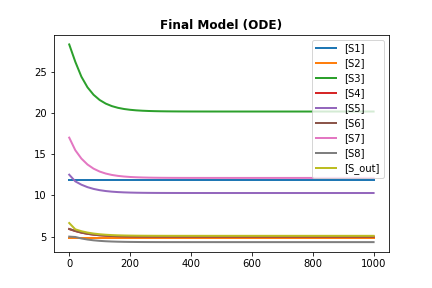

In [93]:
r_8_sim = SimulateData(r_8_species)
r_8_sim.sim_with_adjustment(species_adjust = ['S_in', 'S1', 'S2'], sim_type = 'sde', full_time = True)
sde_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

r_8_sim.sim_with_adjustment(species_adjust = ['S_in', 'S1', 'S2'], sim_type = 'ode', full_time = True)
ode_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

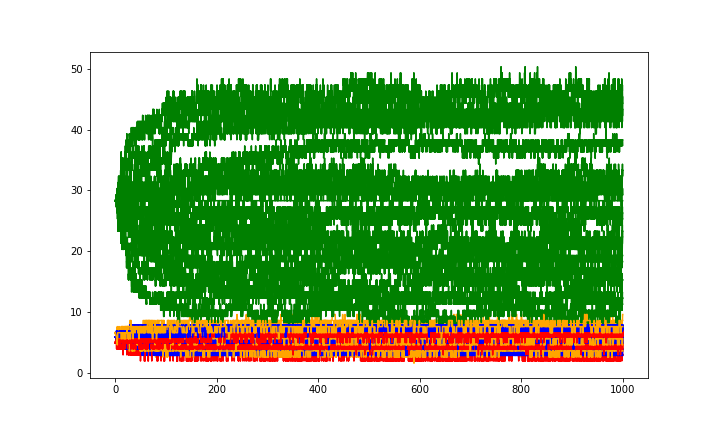

In [56]:
for x in range(0, len(ode_results)):
    ode_results[x] = pd.DataFrame(sde_results[x], 
                                  columns = ['time', '[S1]', '[S2]', '[S3]', '[S4]', '[S5]', 
                                             '[S6]', '[S7]', '[S8]', '[S_out]'])
    ode_results[x].loc[:, 'Sim'] = 'Sim_{0}'.format(str(x))
    
combined_ode = pd.concat(ode_results)
plot_df = combined_ode.loc[combined_ode['Sim'].isin(['Sim_{0}'.format(x) for x in range(0,20)])]

fig, ax = plt.subplots(figsize = (10,6))
for x in range(0,20):
    temp = plot_df.loc[plot_df['Sim'] == 'Sim_{0}'.format(x)]
    ax.plot(temp['time'], temp['[S8]'], color = 'red')
    ax.plot(temp['time'], temp['[S6]'], color = 'blue')
    ax.plot(temp['time'], temp['[S3]'], color = 'green')
    ax.plot(temp['time'], temp['[S_out]'], color = 'orange')

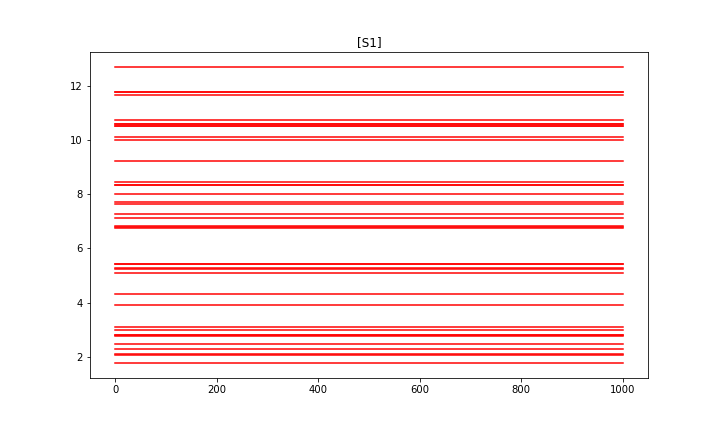

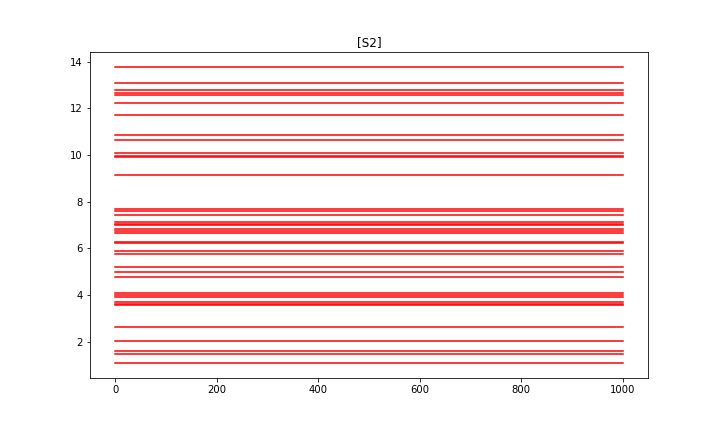

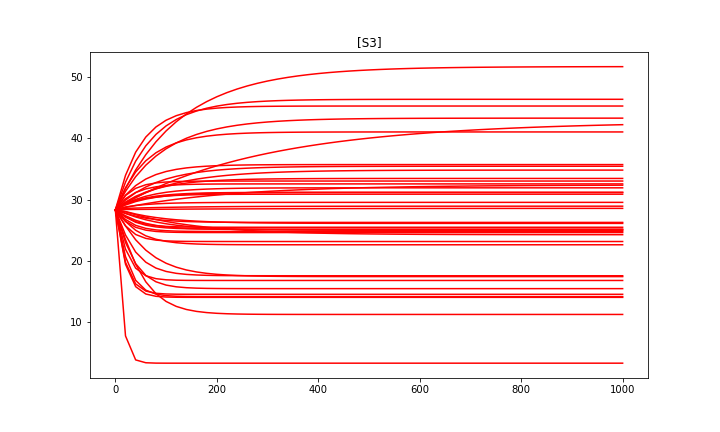

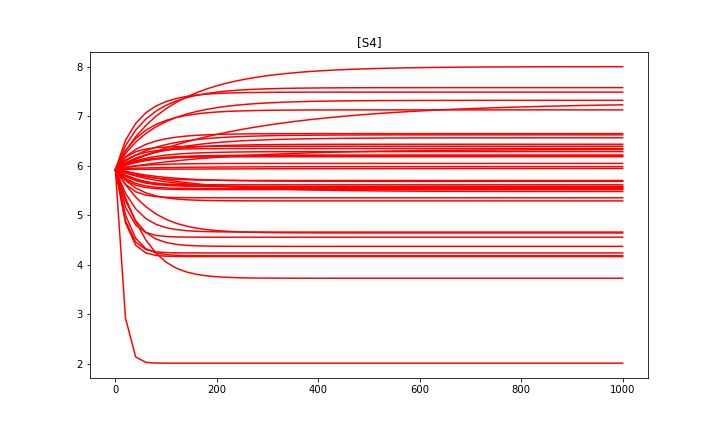

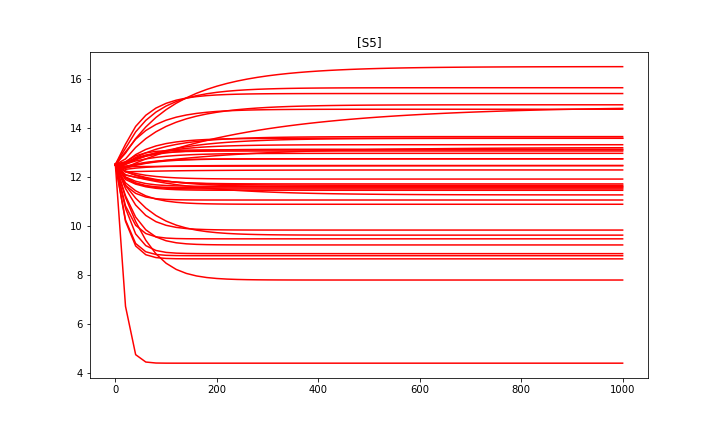

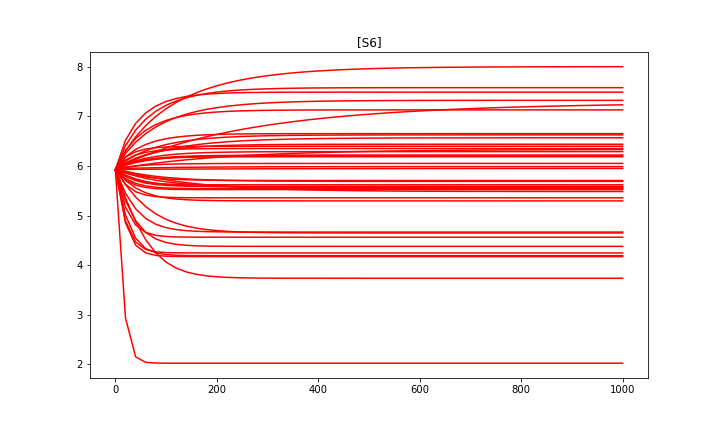

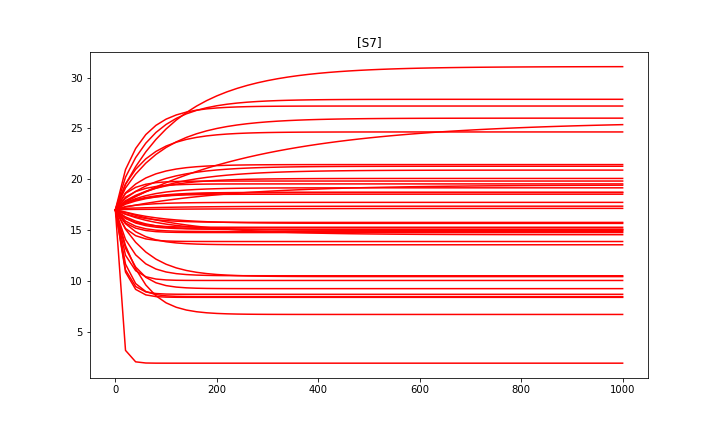

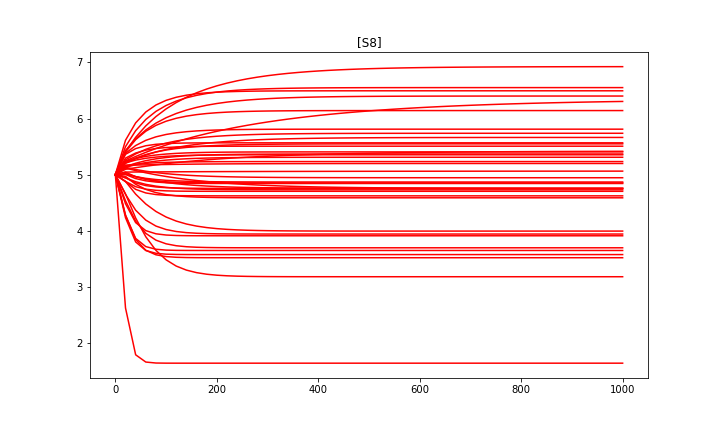

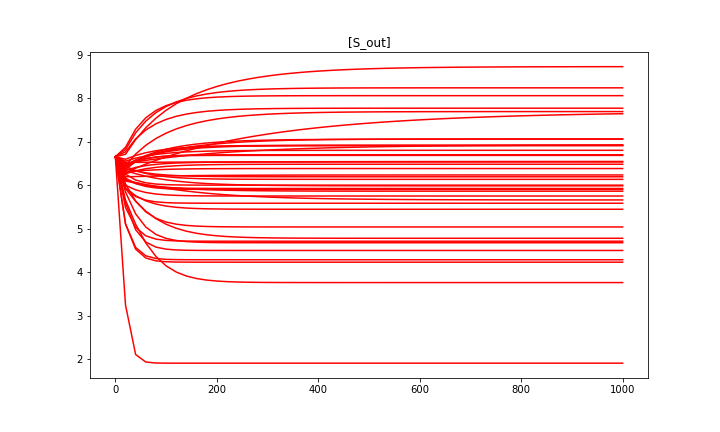

In [97]:
for x in range(0, len(ode_results)):
    ode_results[x] = pd.DataFrame(ode_results[x], 
                                  columns = ['time', '[S1]', '[S2]', '[S3]', '[S4]', '[S5]', 
                                             '[S6]', '[S7]', '[S8]', '[S_out]'])
    ode_results[x].loc[:, 'Sim'] = 'Sim_{0}'.format(str(x))
    
combined_ode = pd.concat(ode_results)
plot_df = combined_ode.loc[combined_ode['Sim'].isin(['Sim_{0}'.format(x) for x in range(0,500)])]

plot_list = ['[S{0}]'.format(str(x)) for x in range(1, 9)]
plot_list.append('[S_out]')

for s in plot_list:
    fig, ax = plt.subplots(figsize = (10,6))
    for x in range(0,40):
        temp = plot_df.loc[plot_df['Sim'] == 'Sim_{0}'.format(x)]
        ax.plot(temp['time'], temp[s], color = 'red')
        ax.set_title(s)

In all versions of simulation, we reach a different steady state for each simulation.

### All Species Random Initialization

Random intial state for all species. Plot true relationships.

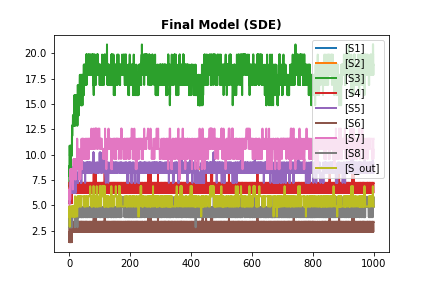

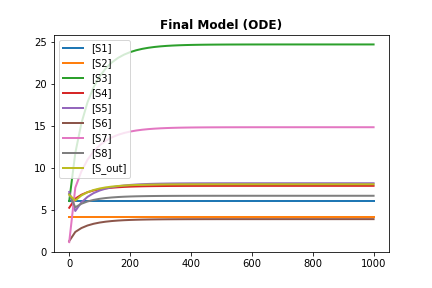

In [170]:
r_8_sim = SimulateData(r_8_species)
r_8_sim.sim_with_adjustment(sim_type = 'sde')
sde_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

r_8_sim.sim_with_adjustment(sim_type = 'ode')
ode_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

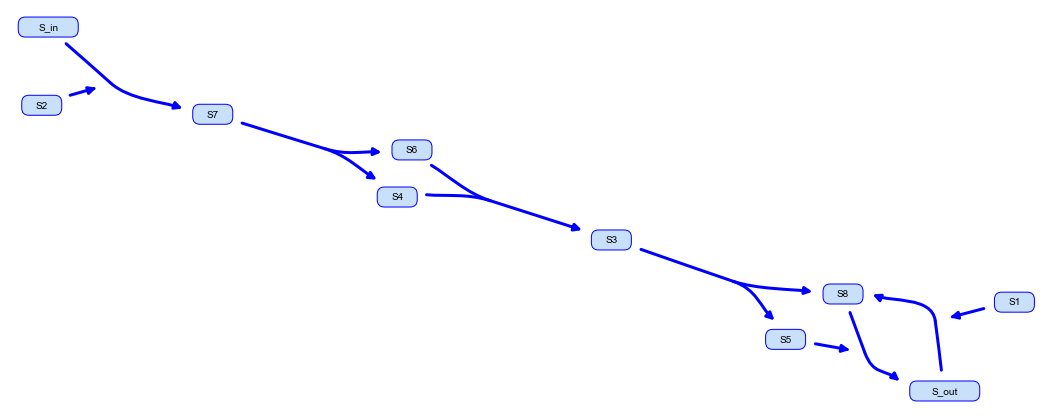

In [71]:
s.drawNetwork(r"..\networks\8_species_network-1.pdf", show=False)

In [11]:
def comparison_plt_2d(s1, s2):
    
    fig, ax = plt.subplots(1,2, figsize = (10,4))
    
    ax[0].scatter(sde_results[s1], sde_results[s2], alpha = .5)
    ax[0].set_title('SDE')
    ax[0].set_xlabel(s1)
    ax[0].set_ylabel(s2)
    
    ax[1].scatter(ode_results[s1], ode_results[s2], alpha = .5)
    ax[1].set_title('ODE')
    ax[1].set_xlabel(s1)
    ax[1].set_ylabel(s2)
    
    plt.suptitle('{0} vs {1}'.format(s1,s2))


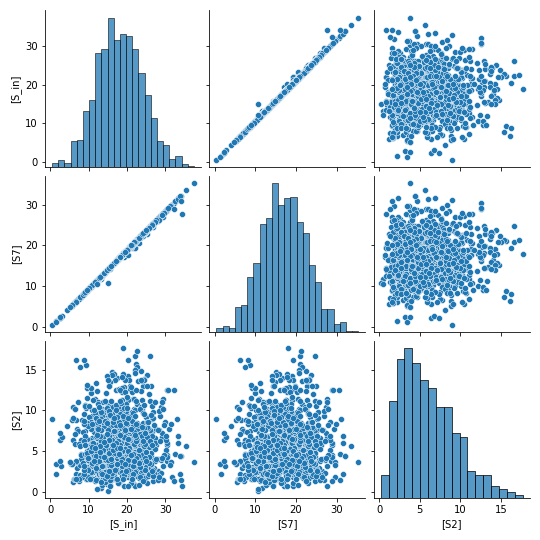

In [171]:
sns.pairplot(ode_results.loc[:, ['[S_in]', '[S7]', '[S2]']])

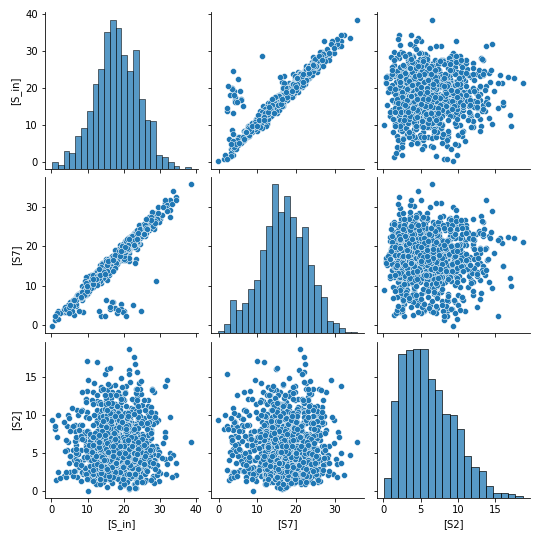

In [172]:
sns.pairplot(sde_results.loc[:, ['[S_in]', '[S7]', '[S2]']])

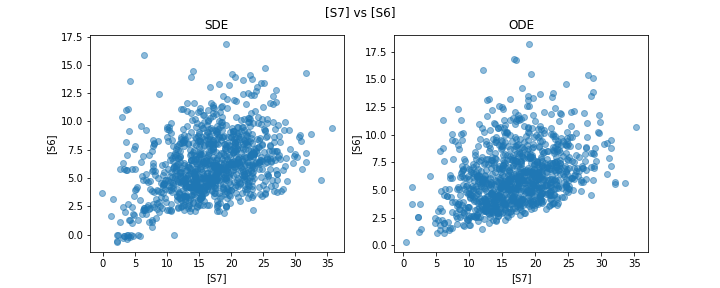

In [173]:
comparison_plt_2d('[S7]', '[S6]')

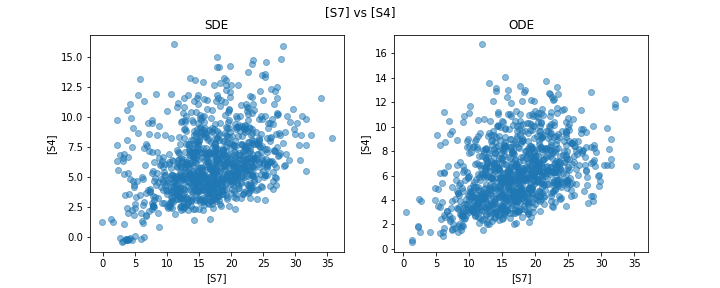

In [174]:
comparison_plt_2d('[S7]', '[S4]')

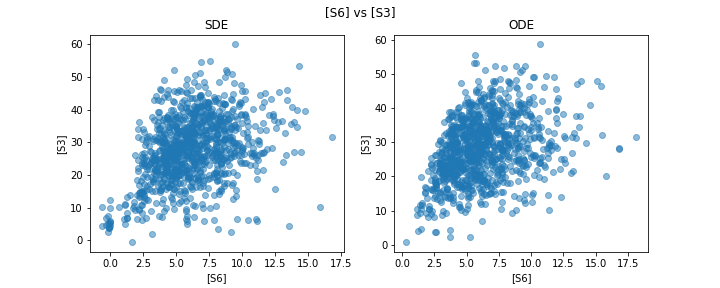

In [175]:
comparison_plt_2d('[S6]', '[S3]')

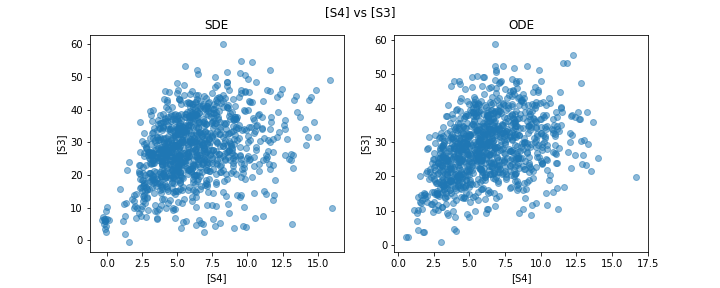

In [176]:
comparison_plt_2d('[S4]', '[S3]')

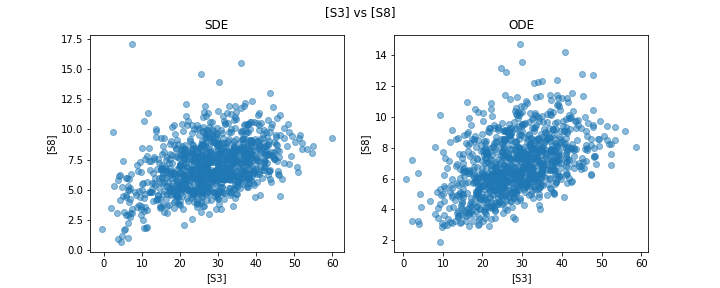

In [177]:
comparison_plt_2d('[S3]', '[S8]')

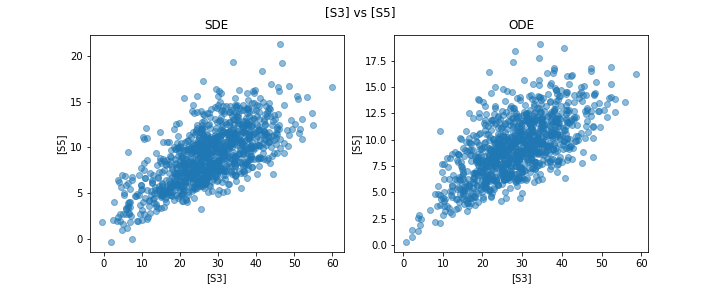

In [178]:
comparison_plt_2d('[S3]', '[S5]')

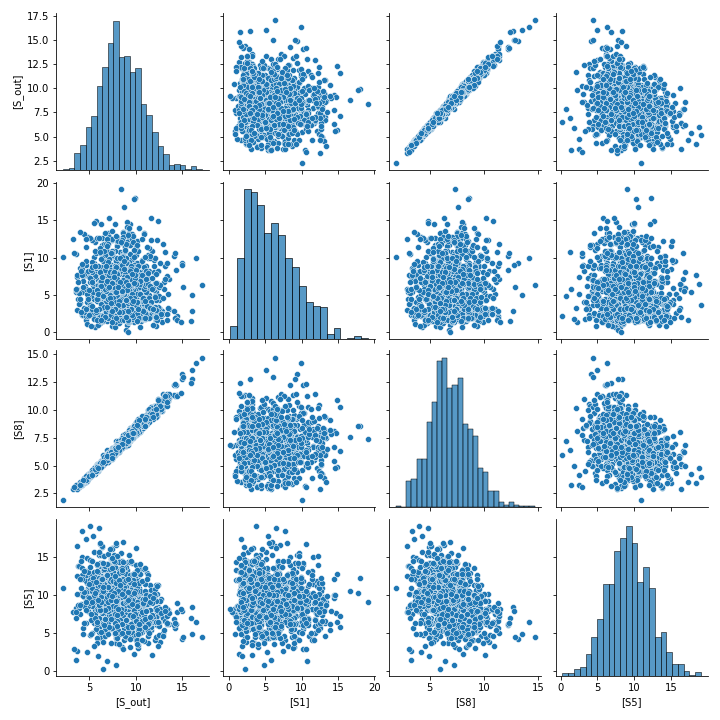

In [179]:
sns.pairplot(ode_results.loc[:, ['[S_out]', '[S1]', '[S8]', '[S5]']])

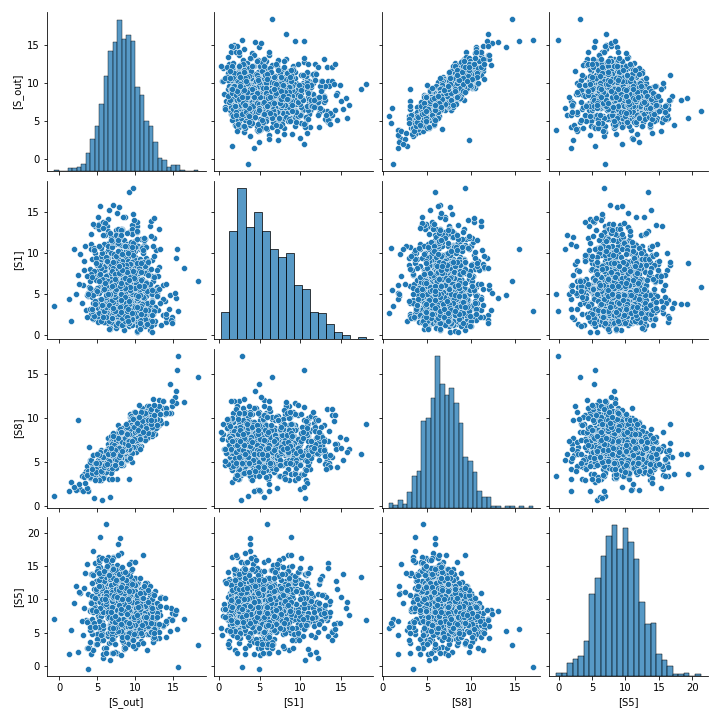

In [180]:
sns.pairplot(sde_results.loc[:, ['[S_out]', '[S1]', '[S8]', '[S5]']])

### Input Species Random Initialization

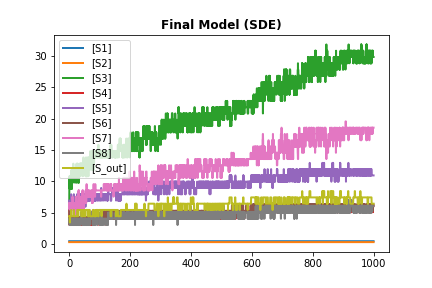

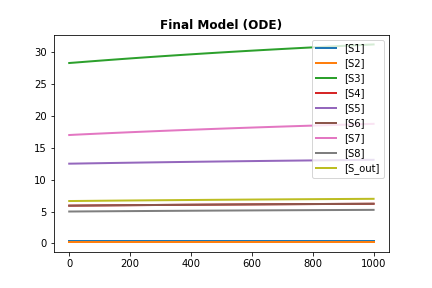

In [63]:
r_8_sim = SimulateData(r_8_species)
r_8_sim.sim_with_adjustment(species_adjust = ['S_in', 'S1', 'S2'], 
                            species_manual_adjust = {'S3' : random.random(), 'S4' : random.random(), 
                                                     'S5' : random.random(), 'S6' : random.random(), 
                                                     'S7' : random.random(), 'S8' : random.random(), 
                                                     'S_out' : random.random()}, sim_type = 'sde')
sde_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

r_8_sim.sim_with_adjustment(species_adjust = ['S_in', 'S1', 'S2'], sim_type = 'ode')
ode_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

Text(0.5, 0.98, 'SDE')

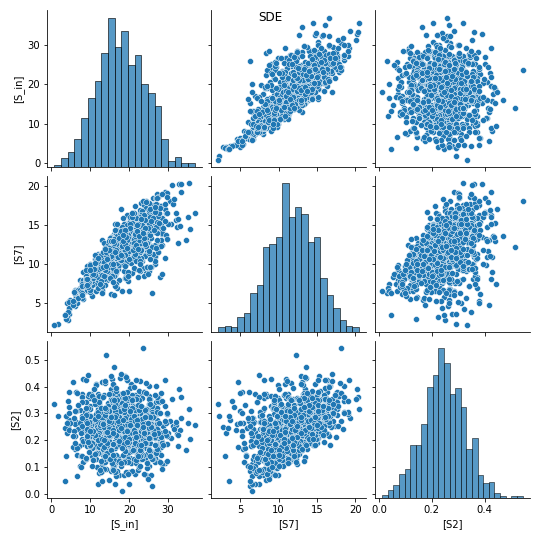

In [64]:
g = sns.pairplot(sde_results.loc[:, ['[S_in]', '[S7]', '[S2]']])
g.fig.suptitle('SDE')

Text(0.5, 0.98, 'ODE')

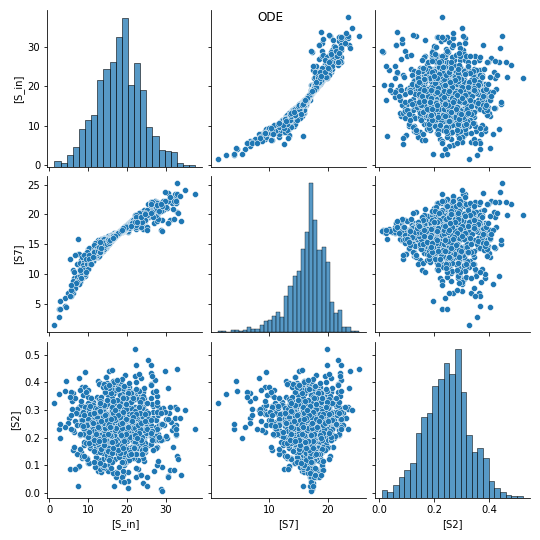

In [65]:
g = sns.pairplot(ode_results.loc[:, ['[S_in]', '[S7]', '[S2]']])
g.fig.suptitle('ODE')

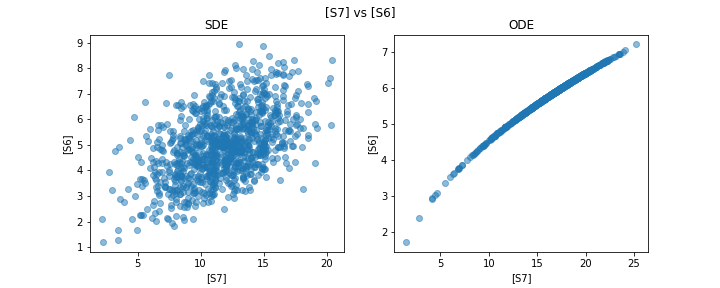

In [66]:
comparison_plt_2d('[S7]', '[S6]')

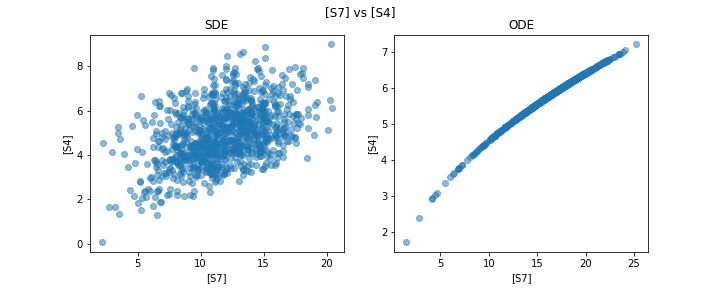

In [67]:
comparison_plt_2d('[S7]', '[S4]')

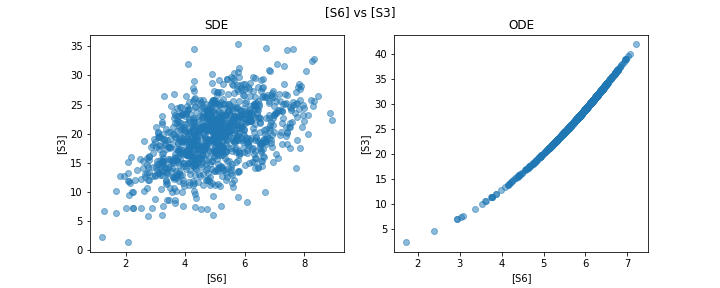

In [68]:
comparison_plt_2d('[S6]', '[S3]')

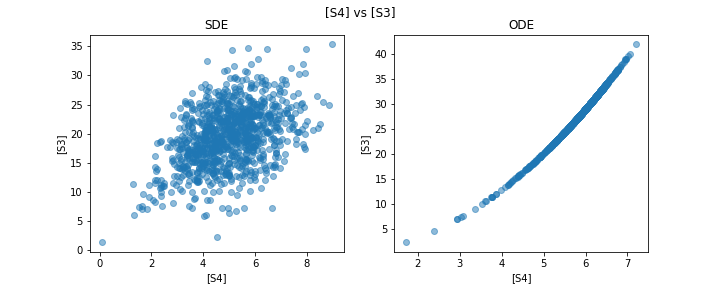

In [69]:
comparison_plt_2d('[S4]', '[S3]')

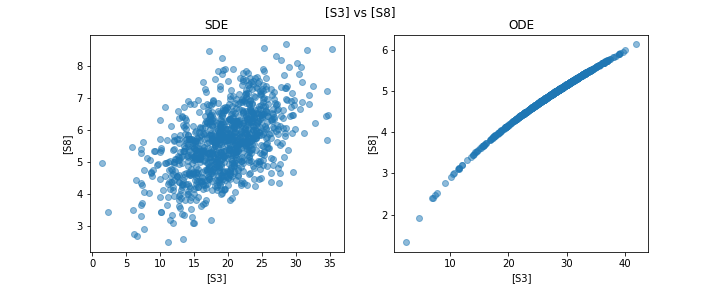

In [70]:
comparison_plt_2d('[S3]', '[S8]')

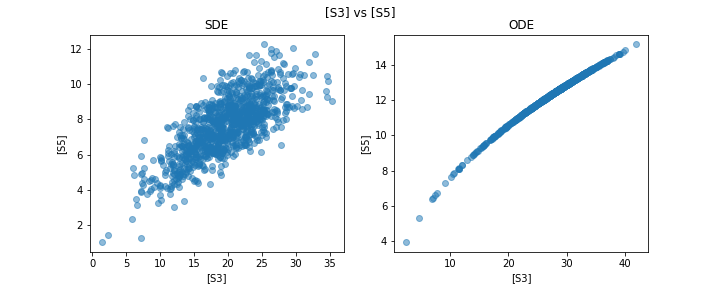

In [71]:
comparison_plt_2d('[S3]', '[S5]')

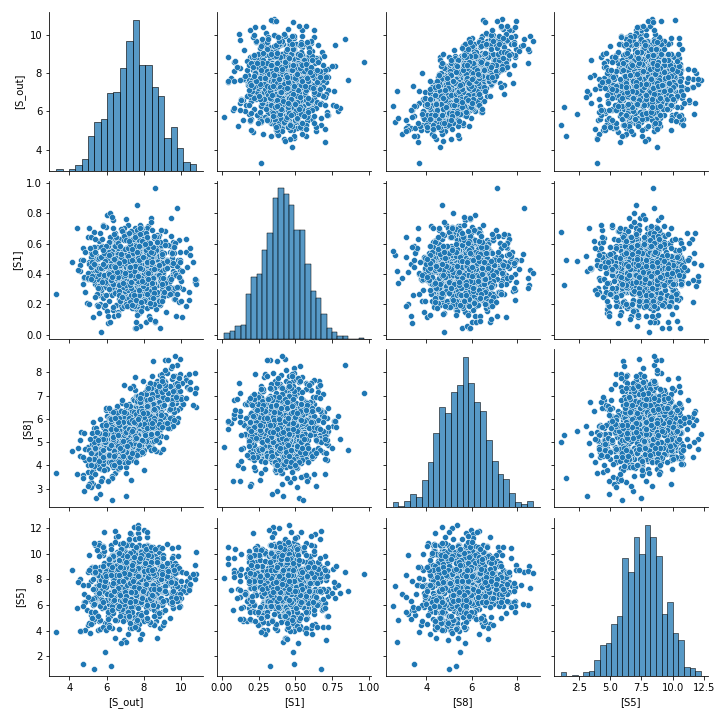

In [72]:
sns.pairplot(sde_results.loc[:, ['[S_out]', '[S1]', '[S8]', '[S5]']])

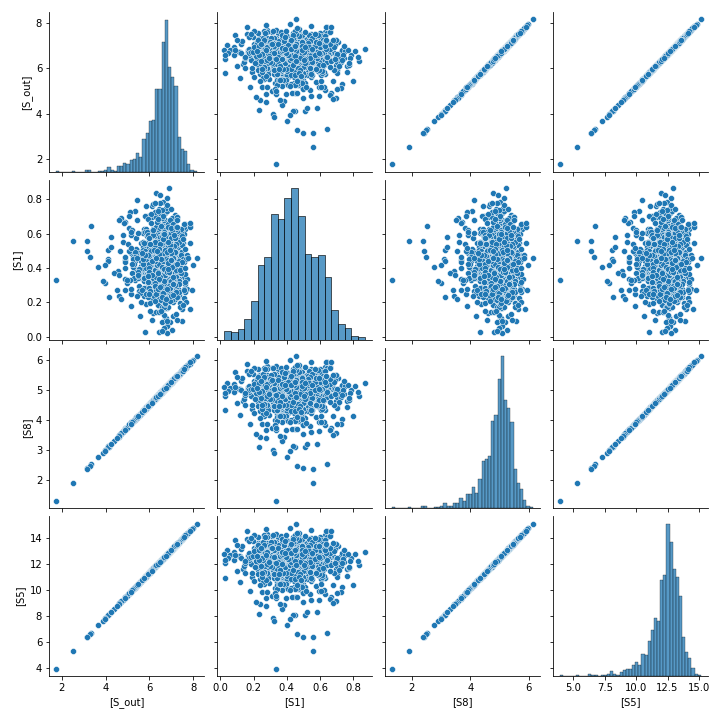

In [73]:
sns.pairplot(ode_results.loc[:, ['[S_out]', '[S1]', '[S8]', '[S5]']])

In [86]:
sde_results.to_csv('..\Data\sde_simulation.csv')

### Random Initialized Rates

r1: $S_in => S7; S2*(kf_J1*S_in/K1_J1 - kr_J1*S7/K2_J1)/(1 + S_in/K1_J1 + S7/K2_J1);
r2: S8 => S_out; S5*(kf_J2*S8/K1_J2 - kr_J2*S_out/K2_J2)/(1 + S8/K1_J2 + S_out/K2_J2);
r3: S_out => S8; S1*(kf_J3*S_out/K2_J3 - kr_J3*S8/K1_J3)/(1 + S_out/K2_J3 + S8/K1_J3);
r4: S3 => S8 + S5; kf_J4*S3 - kr_J4*S8*S5;
r5: S7 => S6 + S4; kf_J5*S7 - kr_J5*S6*S4;
r6: S4 + S6 => S3; kf_J6*S4*S6 - kr_J6*S3;

Variable initializations:
kf_J1 = 0.307895461529232;
kr_J1 = 0.387815602195698;
K1_J1 = 0.64223931723308;
K2_J1 = 0.763744767124324;
kf_J2 = 0.787213757678845;
kr_J2 = 0.266573890463408;
K1_J2 = 0.410928960183146;
K2_J2 = 0.186684558077676;
kf_J3 = 0.550805951932661;
kr_J3 = 0.403058667570072;
K1_J3 = 0.260720667971249;
K2_J3 = 0.378534008271946;
kf_J4 = 0.743548813554282;
kr_J4 = 0.33628762781016;
kf_J5 = 0.825169644172124;
kr_J5 = 0.400064686023475;
kf_J6 = 0.670237604771845;
kr_J6 = 0.830452020005181;

In [102]:
r_8_sim = SimulateData(r_8_species)
r_8_sim.sim_with_adjustment(species_adjust = ['S2'], rates_adjust = ['kf_J1', 'K1_J1', 'kr_J1', 'K2_J1'], sim_type = 'SDE')
new_rates = pd.DataFrame(data = r_8_sim.rates, columns = r_8_species.getGlobalParameterIds())
sim_results = r_8_sim.sim_results

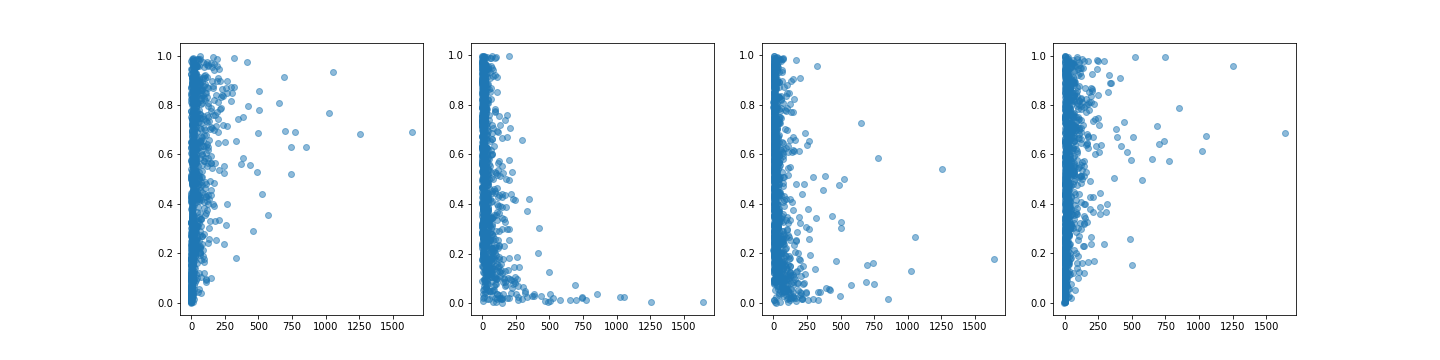

In [106]:
fig, ax = plt.subplots(1,4,figsize = (20,5))

ax[0].scatter(sim_results['[S7]'], new_rates['kf_J1'], alpha = .5)
ax[1].scatter(sim_results['[S7]'], new_rates['K1_J1'], alpha = .5)
ax[2].scatter(sim_results['[S7]'], new_rates['kr_J1'], alpha = .5)
ax[3].scatter(sim_results['[S7]'], new_rates['K2_J1'], alpha = .5)

In [168]:
r_8_sim = SimulateData(r_8_species)
r_8_sim.sim_with_adjustment(species_adjust = ['S1'], rates_adjust = ['kf_J3', 'K2_J3', 'kr_J3', 'K1_J3'], sim_type = 'SDE')
new_rates = pd.DataFrame(data = r_8_sim.rates, columns = r_8_species.getGlobalParameterIds())
sim_results = r_8_sim.sim_results

Text(0.5, 1.0, 'K1_J3')

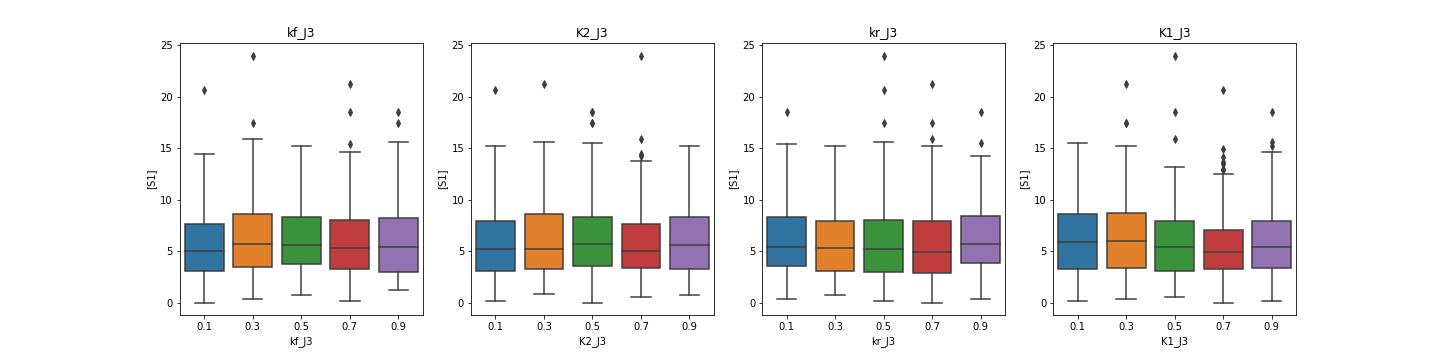

In [169]:
fig, ax = plt.subplots(1,4,figsize = (20,5))

sns.boxplot(x = new_rates['kf_J3'], y = sim_results['[S1]'], ax = ax[0])
sns.boxplot(x = new_rates['K2_J3'], y = sim_results['[S1]'], ax = ax[1])
sns.boxplot(x = new_rates['kr_J3'], y = sim_results['[S1]'], ax = ax[2])
sns.boxplot(x = new_rates['K1_J3'], y = sim_results['[S1]'], ax = ax[3])
ax[0].set_title('kf_J3')
ax[1].set_title('K2_J3')
ax[2].set_title('kr_J3')
ax[3].set_title('K1_J3')

Text(0.5, 1.0, 'K1_J3')

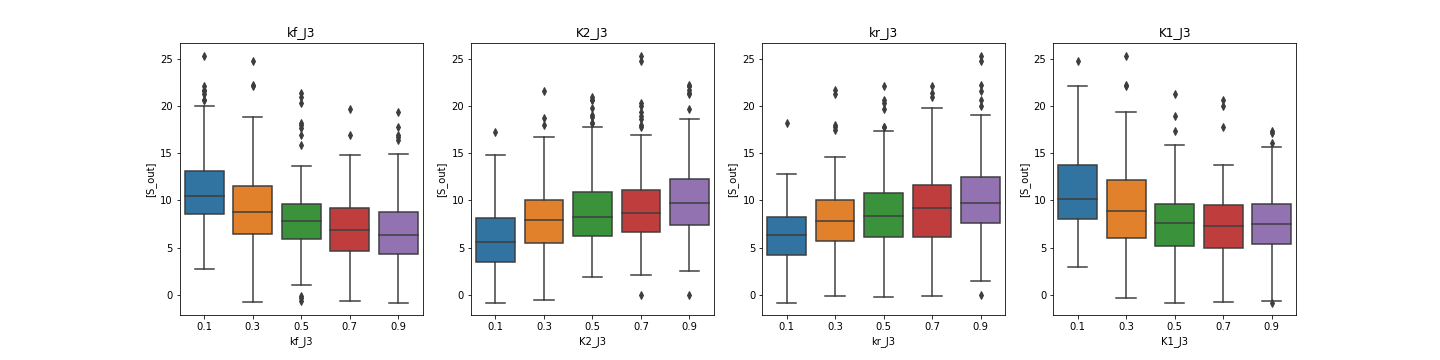

In [161]:
fig, ax = plt.subplots(1,4,figsize = (20,5))

sns.boxplot(x = new_rates['kf_J3'], y = sim_results['[S_out]'], ax = ax[0])
sns.boxplot(x = new_rates['K2_J3'], y = sim_results['[S_out]'], ax = ax[1])
sns.boxplot(x = new_rates['kr_J3'], y = sim_results['[S_out]'], ax = ax[2])
sns.boxplot(x = new_rates['K1_J3'], y = sim_results['[S_out]'], ax = ax[3])
ax[0].set_title('kf_J3')
ax[1].set_title('K2_J3')
ax[2].set_title('kr_J3')
ax[3].set_title('K1_J3')

In [150]:
sim_results.head()

time      [S1]      [S2]       [S3]       [S4]       [S5]      [S6]  \
0  999.0  6.265329  0.982414  30.163828   7.124929   6.405488  5.375596   
1  999.0  8.548339  7.357350  35.546514   5.709480   5.715368  7.954460   
2  999.0  3.533266  9.953895  35.072424  10.551809  10.403692  4.364740   
3  999.0  7.734163  1.306598  36.461136   8.005251  10.996989  4.955515   
4  999.0  4.777976  3.955030  25.655464   5.372275   8.720504  5.797911   

        [S7]       [S8]    [S_out]     [S_in]  
0  18.222051   9.270866   8.328721  19.721853  
1  19.782605  17.091562   7.270944  22.701566  
2  20.418547   7.429796  10.732024  22.222294  
3  23.027931   5.753442   8.657463  23.232692  
4  15.613264   5.433080  10.998312  16.002150

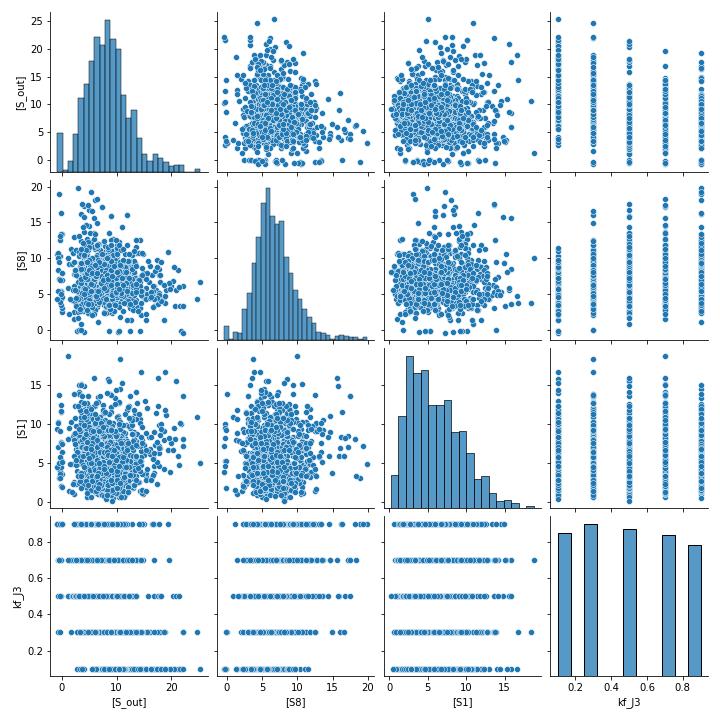

In [151]:
sns.pairplot(pd.concat([sim_results.loc[:, ['[S_out]', '[S8]', '[S1]']], new_rates['kf_J3']], axis = 1))

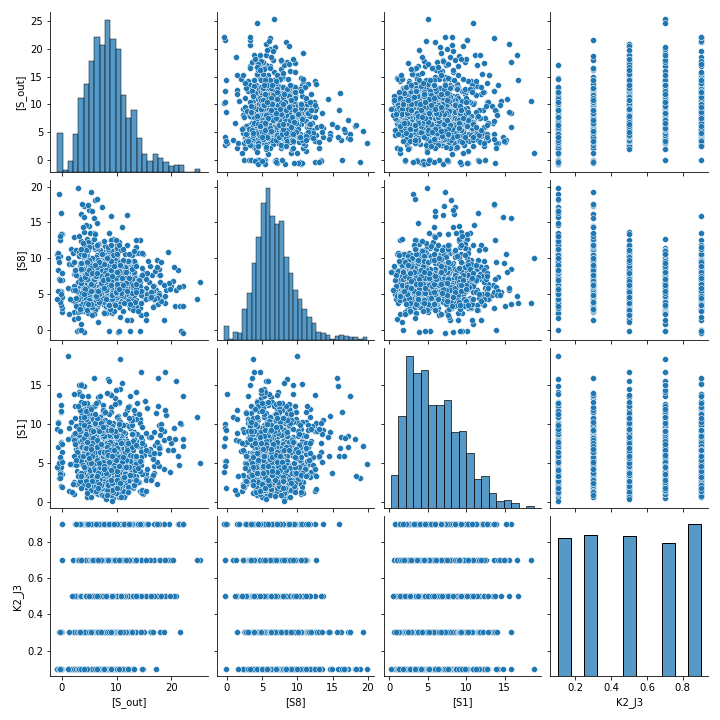

In [152]:
sns.pairplot(pd.concat([sim_results.loc[:, ['[S_out]', '[S8]', '[S1]']], new_rates['K2_J3']], axis = 1))

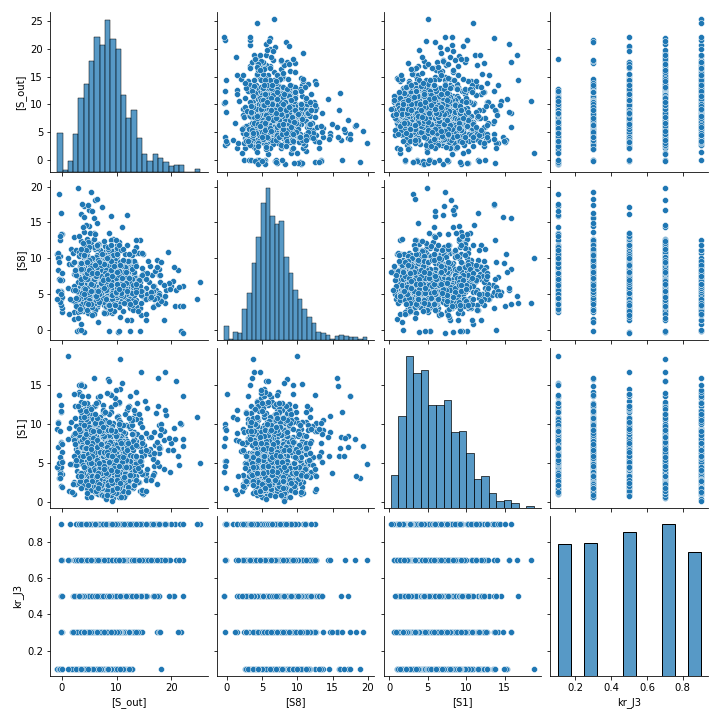

In [153]:
sns.pairplot(pd.concat([sim_results.loc[:, ['[S_out]', '[S8]', '[S1]']], new_rates['kr_J3']], axis = 1))

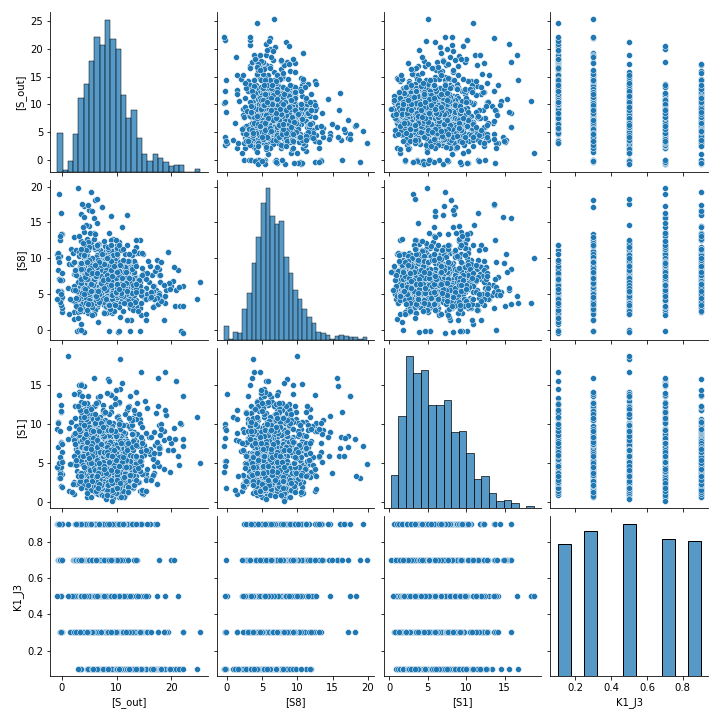

In [154]:
sns.pairplot(pd.concat([sim_results.loc[:, ['[S_out]', '[S8]', '[S1]']], new_rates['K1_J3']], axis = 1))

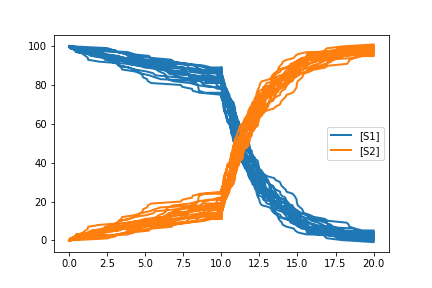

In [76]:
r = te.loada('S1 -> S2; k1*S1; k1 = 0.02; S1 = 100.1')
r.setSeed(1234)
for k in range(1, 20):
    r.resetToOrigin()
    res1 = r.gillespie(0, 10)
    r.plot(res1, show=False) # plot first half of data

    # change in parameter after the first half of the simulation
    # We could have also used an Event in the antimony model,
    # which are described further in the Antimony Reference section
    r.k1 = r.k1*20
    res2 = r.gillespie (10, 20)

    r.plot(res2, show=False) # plot second half of data

te.show()

In [77]:
res1

        time,  [S1], [S2]
 [[        0, 100.1,    0],
  [ 0.107904,  99.1,    1],
  [ 0.473749,  98.1,    2],
  [ 0.540833,  97.1,    3],
  [  1.51015,  96.1,    4],
  [  2.29861,  95.1,    5],
  [  2.46172,  94.1,    6],
  [  3.90986,  93.1,    7],
  [  4.01939,  92.1,    8],
  [  4.10141,  91.1,    9],
  [  5.99727,  90.1,   10],
  [  7.49894,  89.1,   11],
  [  7.91901,  88.1,   12],
  [   8.8167,  87.1,   13],
  [  9.67186,  86.1,   14],
  [       10,  86.1,   14]]

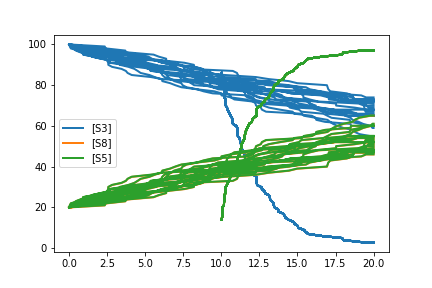

In [83]:
r = te.loada('S3 -> S8 + S5; k1*S3; k1 = 0.02; S3 = 100; S8 = 20; S5 = 20.1')
r.setSeed(1234)
for k in range(1, 20):
    r.resetToOrigin()
    res1 = r.gillespie(0, 20)
    r.plot(res1, show=False) # plot first half of data


    r.plot(res2, show=False) # plot second half of data

te.show()

In [84]:
res1

        time, [S3], [S8], [S5]
 [[        0,  100,   20, 20.1],
  [ 0.247987,   99,   21, 21.1],
  [ 0.253795,   98,   22, 22.1],
  [  1.01687,   97,   23, 23.1],
  [  1.29128,   96,   24, 24.1],
  [  1.38517,   95,   25, 25.1],
  [  1.50757,   94,   26, 26.1],
  [  2.09853,   93,   27, 27.1],
  [    2.652,   92,   28, 28.1],
  [  2.67412,   91,   29, 29.1],
  [  3.49666,   90,   30, 30.1],
  [  4.35964,   89,   31, 31.1],
  [  5.41096,   88,   32, 32.1],
  [  5.80948,   87,   33, 33.1],
  [   6.5808,   86,   34, 34.1],
  [   6.9224,   85,   35, 35.1],
  [  8.46266,   84,   36, 36.1],
  [  9.04093,   83,   37, 37.1],
  [   9.5073,   82,   38, 38.1],
  [  9.65994,   81,   39, 39.1],
  [  9.86234,   80,   40, 40.1],
  [  10.7776,   79,   41, 41.1],
  [   13.124,   78,   42, 42.1],
  [   13.994,   77,   43, 43.1],
  [  14.5728,   76,   44, 44.1],
  [  17.7173,   75,   45, 45.1],
  [  18.2185,   74,   46, 46.1],
  [  18.3264,   73,   47, 47.1],
  [  18.3811,   72,   48, 48.1],
  [  19.3974

### Old stuff

In [ ]:
## Old code
    def sim_with_species_adj(self, species_adjust = list(), sim_type = 'SDE', n = 1000, distribution = 'Gaussian', full_time = False):
        """
        Function to simulate data with different starting species concentrations
        ---

        species: list of species to adjust starting points, if blank then adjusts all starting points
        sim_type: one of either SDE or ODE used for simulation.
        n: number of simulations to make
        distribution: What type of distribution starting points should be sampled from
        full_time: return all timestamps (False) or just final (True)
        """
        
        self.species_adjust = species_adjust
        self.distribution = distribution
        self.sim_type = sim_type
        
        if self.distribution == 'Gaussian':
            dist = np.random.normal
        else:
            print('Only normal distributions supported')
            return
        
        self.sim_type = self.sim_type.upper()
        if self.sim_type not in ['SDE', 'ODE']:
            print('sim_type must be one of the following: sde, ode')
            return
        
        ## Initialize species parameters and lists for simulated values
        dataset = list()
        S_in = list()
        params = self.sbml.getFloatingSpeciesConcentrationIds()
        params = ['S_in'] + params ## S_in not included in param listing
        
        ## TODO: Determine best way to adjust species. How to define mean
        ##        and variance. Discrete value or based on initial params.
        for x in range(0, n):
            if len(self.species_adjust) > 0:
                for s in self.species_adjust:
                    #temp_mean = sbml.model['init([{0}])'.format(s)]
                    if s == 'S_in':
                        temp_mean = random.randint(2,10)
                        new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                        while new_val < 0:
                            new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                        self.sbml.model[s] = new_val
                    else:
                        temp_mean = random.randint(2,10)
                        new_val = dist(temp_mean, temp_mean / 3)
                        while new_val < 0:
                            new_val = dist(temp_mean, temp_mean / 3)
                        self.sbml.model['init([{0}])'.format(s)] = new_val
                S_in.append(self.sbml.model['S_in'])
            else:
                for s in params:
                    #temp_mean = sbml.model['init({0})'.format(s)]
                    if s == 'S_in':
                        temp_mean = random.randint(2,10)
                        new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                        while new_val < 0:
                            new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                        self.sbml.model[s] = new_val
                    else:
                        temp_mean = random.randint(2,10)
                        new_val = dist(temp_mean, temp_mean / 3)
                        while new_val < 0:
                            new_val = dist(temp_mean, temp_mean / 3)
                        self.sbml.model['init({0})'.format(s)] = new_val
                S_in.append(self.sbml.model['S_in'])
            
            ## Simulate data depending on sim_type
            self.sbml.setSeed(1234)
            if self.sim_type == 'ODE':
                model_results = self.sbml.simulate(0, 1000)
            else:
                model_results = self.sbml.gillespie(0, 1000)
            
            if full_time == False:
                temp_result = model_results[-1]
                dataset.append(temp_result)
            else:
                dataset.append(model_results)
            self.final_model = model_results
            self.sbml.resetToOrigin()
        
        ## Push results to pandas dataframe
        if full_time == False:
            params.pop(0)
            dataset = pd.DataFrame(dataset, columns = ['time'] + params)
            dataset.loc[:, '[S_in]'] = S_in
        
        self.sim_results = dataset

    def sim_with_rate_adj(self, rate_adjust = list(), sim_type = 'SDE', n = 1000, full_time = False):
        """
        Function to simulate data with different starting parameters
        NOTE: function not finished. Need to determine correct distriubtion to intialize parameters at.
        ---

        species: list of species to adjust starting points, if blank then adjusts all starting points
        sim_type: one of either SDE or ODE used for simulation.
        n: number of simulations to make
        """

        self.rate_adjust = rate_adjust
        self.sim_type = sim_type
        
        ## Initialize species parameters and lists for simulated values
        dataset = list()
        rates = self.sbml.getGlobalParameterIds()
        params = self.sbml.getFloatingSpeciesConcentrationIds()
        params = ['S_in'] + params ## S_in not included in param listing
        rates_tracker = list()
        
        for x in range(0, n):
            temp_tracker = list()
            if len(self.rate_adjust) > 0:
                for r in self.rate_adjust:
                    new_rate = np.random.uniform(size=1)[0]
                    self.sbml.model[r] = new_rate
                    temp_tracker.append(new_rate)
            else:
                for r in rates:
                    new_rate = np.random.uniform(size=1)[0]
                    self.sbml.model[r] = new_rate
                    temp_tracker.append(new_rate)
            rates_tracker.append(temp_tracker)
            
            ## Simulate data depending on sim_type
            self.sbml.setSeed(1234)
            if self.sim_type == 'ODE':
                model_results = self.sbml.simulate(0, 1000)
            else:
                model_results = self.sbml.gillespie(0, 1000)
                
            if full_time == False:
                temp_result = model_results[-1]
                dataset.append(temp_result)
            else:
                dataset.append(model_results)
            self.final_model = model_results
            self.sbml.resetToOrigin()
        
        ## Push results to pandas dataframe
        if full_time == False:
            params.pop(0)
            dataset = pd.DataFrame(dataset, columns = ['time'] + params)
        
        self.sim_results = dataset      
        self.set_rates = rates_tracker